In [30]:
###Import the usual libraries
import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

import sklearn
import hdbscan
import sklearn.cluster as skc

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

In [31]:
###Import Data to cluster
monarch = fits.getdata('/Users/joshpovick/Desktop/Research/MS_young/monarch.fits')
monarch = Table(monarch)

###Import Data for velcoity plot
bstpath = '/Users/joshpovick/Desktop/Research/fits/bstars.fits' #original icr stars fits
duppath = '/Users/joshpovick/Desktop/Research/fits/final_dupont_oct09.fits' #original dupont stars
lmcpath = '/Users/joshpovick/Desktop/Research/fits/figure_data_bstars/icstars_lmc_vlsrmlon_lines.fits' #lmc velocity
msvpath = '/Users/joshpovick/Desktop/Research/fits/figure_data_bstars/icstars_hivlsrmlon_lines.fits' #ms velocity
bacpath = '/Users/joshpovick/Desktop/Research/fits/figure_data_bstars/icstars_hivlsrmlon.fits' #HI background

bstars = fits.getdata(bstpath,1)
dupont = fits.getdata(duppath,1)
backgd = fits.getdata(bacpath,1)
lmcvel = fits.getdata(lmcpath,1)
msvelo = fits.getdata(msvpath,1)

In [63]:
#User defined functions
def dup(data):
    keys = []
    values = []
    not_uniq = list(set([x for x in data if data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.squeeze(np.where(data==not_uniq[i])))
    idx = dict(zip(keys, values))
    return not_uniq, idx

In [64]:
test1,test2 = dup(list(monarch['NAME']))
print(test1)
print(test2)

['DI1518', 'DI1480', 'DI1452', 'DI1530']
{'DI1518': array([], dtype=int64), 'DI1480': array([], dtype=int64), 'DI1452': array([], dtype=int64), 'DI1530': array([], dtype=int64)}


In [65]:
###Cluster Data
usurper = np.array([monarch['pmra'],monarch['pmdec'],monarch['parallax']+0.052,monarch['VLSR'],monarch['MLON']]).T

#hdbscan
clustererhdbscan = hdbscan.HDBSCAN(metric='euclidean',min_samples=1,cluster_selection_method='leaf')
clustererhdbscan.fit(usurper)
colhdbscan = clustererhdbscan.labels_

#spectral clustering
clustererspectral = skc.SpectralClustering(n_clusters=50,assign_labels='discretize',random_state=0,n_init=100)
clustererspectral.fit(usurper)
colspectral = clustererspectral.labels_

#k means 
clustererkmeans = skc.KMeans(n_clusters=60, random_state=0)
clustererkmeans.fit(usurper)
colkmeans = clustererkmeans.labels_


In [35]:
#convert to galactocentric coordinates (x,y,z) and get galactocentric velocities and angular momentum
from astropy.coordinates import Distance

galact = []
for i in range(len(monarch)):
    cr = coord.ICRS(ra=monarch['RA'][i]*u.degree, dec=monarch['DEC'][i]*u.degree, \
                        distance=Distance(parallax=(monarch['parallax'][i]+0.052)*u.mas,allow_negative=True),\
                        pm_ra_cosdec=monarch['pmra'][i]*u.mas/u.yr,\
                        pm_dec=monarch['pmdec'][i]*u.mas/u.yr,
                        radial_velocity=monarch['VLSR'][i]*u.km/u.s)
    gcoor = cr.transform_to(coord.Galactocentric)
    galact.append(gcoor)
    
#Extract velocities  
xvel = []
yvel = []
zvel = []

for i in range(len(galact)):
    xvel.append((galact[i].v_x).value)
    yvel.append((galact[i].v_y).value)
    zvel.append((galact[i].v_z).value)
    
xvel=np.squeeze(xvel)
yvel=np.squeeze(yvel)
zvel=np.squeeze(zvel)

#Extract position
xpos = []
ypos = []
zpos = []

for i in range(len(galact)):
    xpos.append((galact[i].x).value*1/1000.) #note conversion from pc to kpc
    ypos.append((galact[i].y).value*1/1000.)
    zpos.append((galact[i].z).value*1/1000.)
    
xpos=np.squeeze(xpos)
ypos=np.squeeze(ypos)
zpos=np.squeeze(zpos)

#Calculate Nagular momentum
s = []
sx = []
sy = []
sz = []
for i in range(len(galact)):
    radius = [xpos[i],ypos[i],zpos[i]]
    velocity = [xvel[i],yvel[i],zvel[i]]
    s.append(np.cross(radius,velocity))
    sx.append(s[i][0])
    sy.append(s[i][1])
    sz.append(s[i][2])

In [ ]:
#Clustering
di15 = np.where(monarch['NAME']=='DI1507')
di14 = np.where(monarch['NAME']=='DI1450')
cpos = np.append(monarch[di15]['MLON'],monarch[di14]['MLON'])
cvel = np.append(monarch[di15]['VLSR'],monarch[di14]['VLSR'])

#HI background
xarr,yarr=np.meshgrid(backgd['XARR'][0],backgd['YARR'][0])
z=backgd['IM'][0]

'''plot with |\mu|'''
fig = plt.figure(figsize=(25,20))
plt.xlim(-30,10)
plt.ylim(-150,374)
plt.gca().invert_xaxis()
#pcm = plt.pcolormesh(xarr, yarr, z, cmap='jet',shading='gouraud') #generate background

plt.plot(msvelo[0][0],msvelo[0][1],'r--',label='LMC filament')
plt.plot(lmcvel[0][0],lmcvel[0][1],c='lime',linestyle='dashed',label='LMC velocity')
plt.plot(lmcvel[0][2],lmcvel[0][3],c='lime',linestyle='dashed')

plt.scatter(monarch['MLON'],monarch['VLSR'],c=np.sqrt(monarch['pmra']**2+monarch['pmdec']**2),marker='*',s=300,label='ICR Stars',cmap='gist_rainbow')

plt.colorbar()
plt.scatter(cpos,cvel,facecolors='none',edgecolors='r',s=500,label='YMSC')

plt.ylabel(r'$V_{LSR}$')
plt.xlabel(r'$L_{MS}$')
plt.title(r'Color as $|\mu|\,(mas\,yr^{-1})$')
plt.savefig('velopos.pdf',bbox_inches='tight')
plt.show()

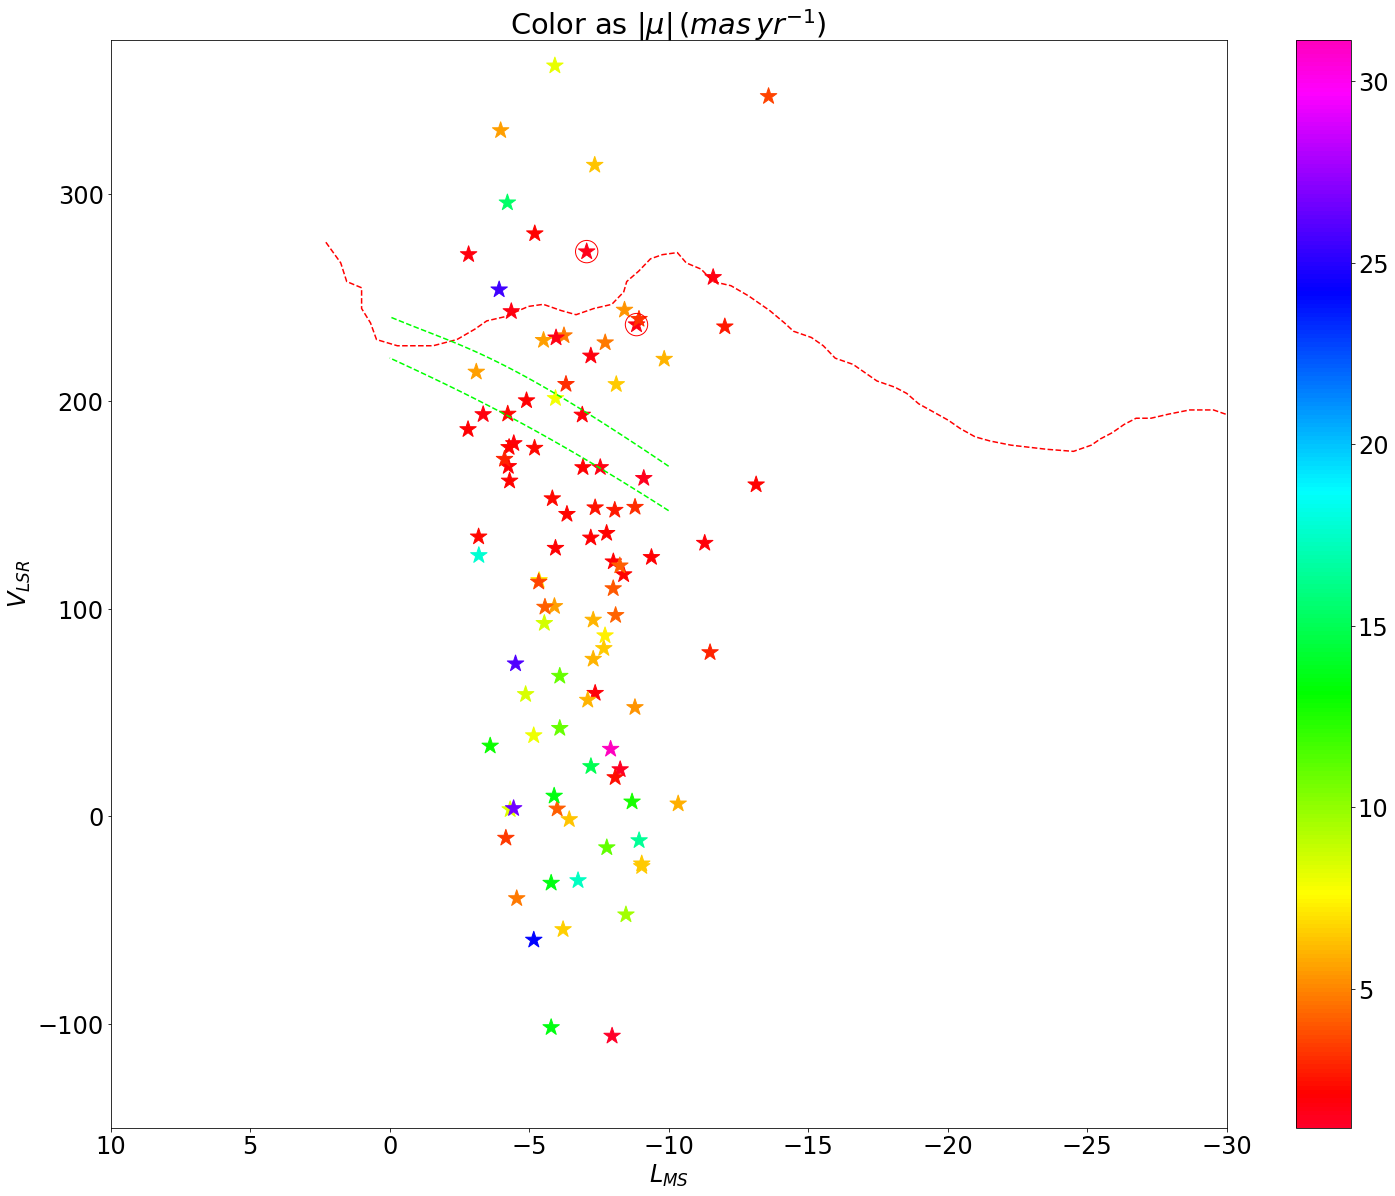

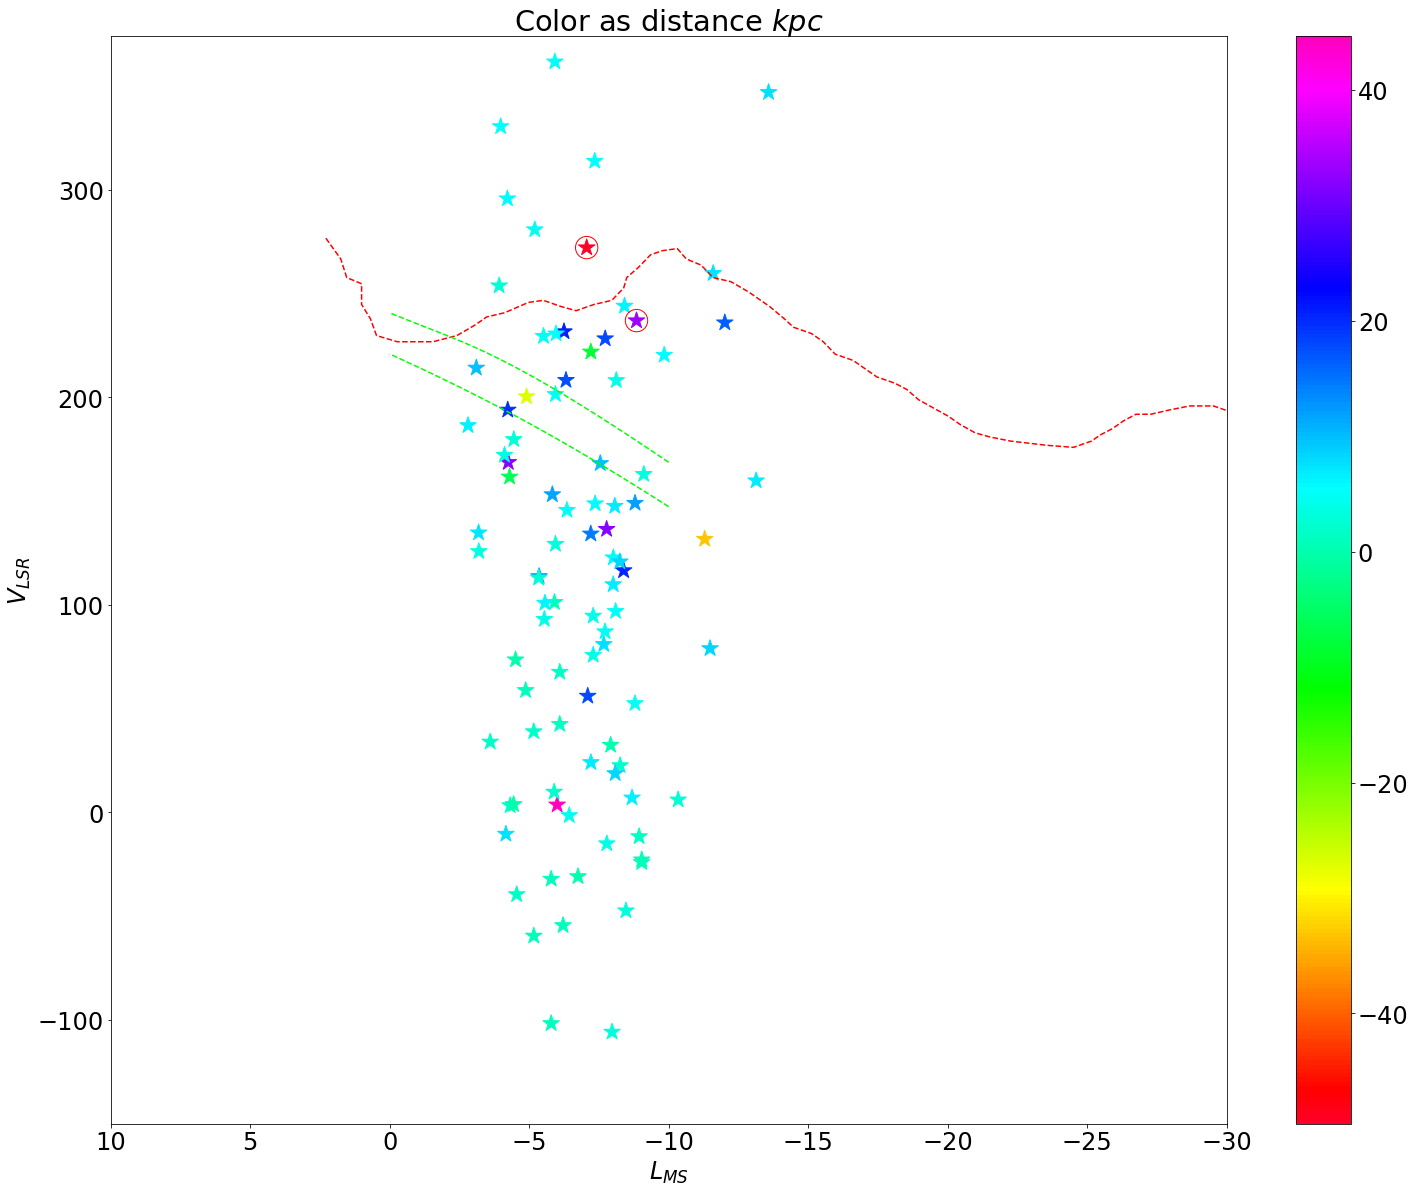

In [36]:
### Velocity Postion plot
#candidate young stars
di15 = np.where(monarch['NAME']=='DI1507')
di14 = np.where(monarch['NAME']=='DI1450')
cpos = np.append(monarch[di15]['MLON'],monarch[di14]['MLON'])
cvel = np.append(monarch[di15]['VLSR'],monarch[di14]['VLSR'])

#HI background
xarr,yarr=np.meshgrid(backgd['XARR'][0],backgd['YARR'][0])
z=backgd['IM'][0]

'''plot with |\mu|'''
fig = plt.figure(figsize=(25,20))
plt.xlim(-30,10)
plt.ylim(-150,374)
plt.gca().invert_xaxis()
#pcm = plt.pcolormesh(xarr, yarr, z, cmap='jet',shading='gouraud') #generate background

plt.plot(msvelo[0][0],msvelo[0][1],'r--',label='LMC filament')
plt.plot(lmcvel[0][0],lmcvel[0][1],c='lime',linestyle='dashed',label='LMC velocity')
plt.plot(lmcvel[0][2],lmcvel[0][3],c='lime',linestyle='dashed')

plt.scatter(monarch['MLON'],monarch['VLSR'],c=np.sqrt(monarch['pmra']**2+monarch['pmdec']**2),marker='*',s=300,label='ICR Stars',cmap='gist_rainbow')

plt.colorbar()
plt.scatter(cpos,cvel,facecolors='none',edgecolors='r',s=500,label='YMSC')

plt.ylabel(r'$V_{LSR}$')
plt.xlabel(r'$L_{MS}$')
plt.title(r'Color as $|\mu|\,(mas\,yr^{-1})$')
plt.savefig('velopos.pdf',bbox_inches='tight')
plt.show()

'''plot with parallax'''
paracut = np.reciprocal(monarch['parallax']+0.052)
clean = np.where((paracut>=-50)&(paracut<=50))
fig = plt.figure(figsize=(25,20))
plt.xlim(-30,10)
plt.ylim(-150,374)
plt.gca().invert_xaxis()
#pcm = plt.pcolormesh(xarr, yarr, z, cmap='jet',shading='gouraud') #generate background

plt.plot(msvelo[0][0],msvelo[0][1],'r--',label='LMC filament')
plt.plot(lmcvel[0][0],lmcvel[0][1],c='lime',linestyle='dashed',label='LMC velocity')
plt.plot(lmcvel[0][2],lmcvel[0][3],c='lime',linestyle='dashed')

plt.scatter(monarch[clean]['MLON'],monarch[clean]['VLSR'],c=np.reciprocal(monarch[clean]['parallax']+0.052),marker='*',s=300,label='ICR Stars',cmap='gist_rainbow')

plt.colorbar()
plt.scatter(cpos,cvel,facecolors='none',edgecolors='r',s=500,label='YMSC')

plt.ylabel(r'$V_{LSR}$')
plt.xlabel(r'$L_{MS}$')
plt.title(r'Color as distance $kpc$')
plt.savefig('velopos.pdf',bbox_inches='tight')
plt.show()

In [52]:
print(np.reciprocal(monarch['parallax'][di14]+0.052))
print(np.reciprocal(monarch['parallax'][di15]+0.052))
print(monarch['designation'][di14])
print(monarch['designation'][di15])

    parallax    
----------------
33.2724110848905
     parallax     
------------------
-49.54168925677503
        designation         
----------------------------
Gaia DR2 4642302336315769728
        designation         
----------------------------
Gaia DR2 4641755879037019264


In [46]:
print(np.round(paracut.data))

[   4.    4.    3.    6.    8.    5.   20.    1.    7.    3.    6.    2.
   21.    5.    5.  -50.    5.   11.    7.    1.    1.    5.    1.    2.
    5.    1.    3.   20.    2.    0.  -27.    6.    1.   45.    1.    8.
    7.   17.    9.    7.  -33.    3.    6.   10.  157.   18.    6.    3.
    4.    7.  -63.   33.    4.    0.   18.  281.   32.    8.    1.   12.
   15.    7.  116.    8.    5.    5.    1.   18.   -8.    5.    3.  -64.
    1.   12.    0.    4.    1.    2.  -67.    4.    2.    3.    8.    5.
    6.    2.    3.    6.    0.   -6. -239.   32.    4.   95.    7.   80.
    4.   10.    7.  157.]


[33.]


In [67]:
distcat = fits.getdata('/Users/joshpovick/Desktop/Research/MS_young/monarchdist-result.fits',1)
distcat['r_est'][di14]

array([8818.47600472])

In [55]:
distcat.columns

ColDefs(
    name = 'source_id'; format = 'K'
    name = 'r_est'; format = 'D'; unit = 'pc'
    name = 'r_lo'; format = 'D'; unit = 'pc'
    name = 'r_hi'; format = 'D'; unit = 'pc'
    name = 'r_len'; format = 'D'; unit = 'pc'
    name = 'result_flag'; format = 'I'
    name = 'modality_flag'; format = 'I'
    name = 'monarch_oid'; format = 'J'
    name = 'col1'; format = 'K'
    name = 'col2'; format = '28A'
    name = 'col3'; format = 'K'
    name = 'col4'; format = 'J'
    name = 'col5'; format = 'E'
    name = 'col6'; format = 'D'
    name = 'col7'; format = 'D'
    name = 'col8'; format = 'D'
    name = 'col9'; format = 'D'
    name = 'col10'; format = 'D'
    name = 'col11'; format = 'D'
    name = 'col12'; format = 'D'
    name = 'col13'; format = 'D'
    name = 'col14'; format = 'D'
    name = 'col15'; format = 'D'
    name = 'col16'; format = 'D'
    name = 'col17'; format = 'D'
    name = 'col18'; format = 'D'
    name = 'col19'; format = 'D'
    name = 'col20'; format = 'D'
